In [1]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [8]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

In [9]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

In [195]:
def lognormal(x,mu,sig):
    return 1/(np.sqrt(2.*np.pi)*sig*x)*np.exp(-np.power((np.log(x) - mu)/sig, 2.)/2)

In [10]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance),average

In [11]:
df=pd.read_csv("NED27.09.1-D-14.2.0-20170929.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])] # only measurements without redshift data are useful here

In [12]:
def selectdata_lite(mymethod,df):
    dfa=df[~np.isfinite(df.err)] # database of non reported errors
    df1=df[np.isfinite(df.err)] # remove measurements that do not report an error
    df1=df1[df1.err!=0] # remove measurements that report an error as zero ¬¬

# Select a method for analysis
    df1=df1[df1.Method==mymethod] # choose a method
    namelist=list(df1['Galaxy ID']) # list of galaxies
    counter=collections.Counter(namelist) # count measurements per galaxy
# Select galaxies with a minimum number of measurements
    ulist=[]
    ulist2=[]
    nmeas=1
    for i in counter.keys():
        if counter[i]>nmeas:
            ulist+=[i] # all galaxies with more than n_meas measurements
        if counter[i]>=1:
            ulist2+=[i] # all galaxies with at least one measurement w/a reported error
    print('No. of Galaxies with reported errors is %i' % len(ulist2) )
    print('No. of Galaxies with more than %i measurements is %i' % (nmeas,len(ulist)) )
# Create database for bootstrap, remove unnecessary columns
    dfs=df1[np.in1d(df1['Galaxy ID'],ulist)] # dataframe with galaxies with more than nmeas measurements
    colu=list(df.columns)
    for i in ['Galaxy ID', 'm-M', 'err', 'D (Mpc)']:
        colu.remove(i)
    dfs.drop(colu, inplace=True, axis=1)
# Create database for non-reported errors
    df1a=dfa[dfa.Method==mymethod] # all measurements without reported errors
    elist=list(np.unique(df1a['Galaxy ID'])) # list of galaxies with measurements without reported errors
    dmeana=[]
    for i in elist:
        dfilter=np.in1d(df1a['Galaxy ID'],i)
        dummy=df1a[dfilter]
        dmeana+=[dummy['D (Mpc)'].mean()] # average reported distance (D), no need for weighted... there are no weights
    filtr=~np.in1d(elist,ulist2)
    nulista=np.asarray(elist)[filtr] # list of galaxies without reported errors
    dista=np.asarray(dmeana)[filtr] # mean distance of galaxies without reported errors
    print('No. of Galaxies without reported errors is %i' % len(nulista) )
    return ulist,dfs,nulista,dista,len(nulista),len(ulist),len(ulist2)

In [13]:
mymethod='Tully-Fisher'
ulist,dfs,nulista,dista,*mma=selectdata_lite(mymethod,df)

No. of Galaxies with reported errors is 11376
No. of Galaxies with more than 1 measurements is 9100


/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


No. of Galaxies without reported errors is 818


7


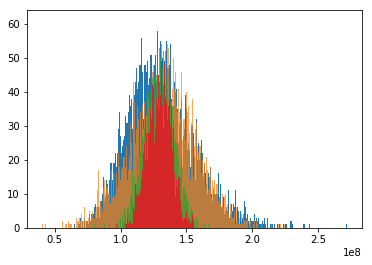

9


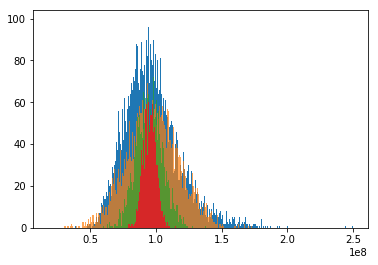

7


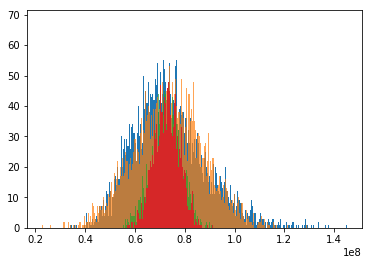

7


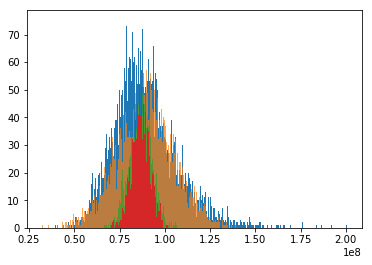

6


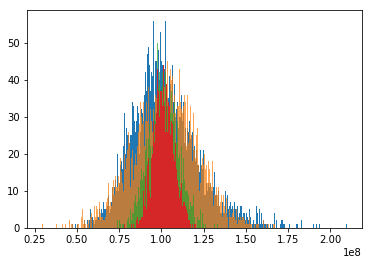

7


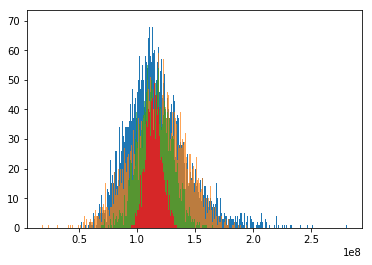

8


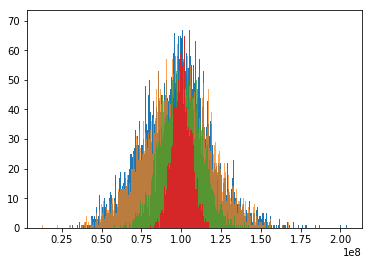

14


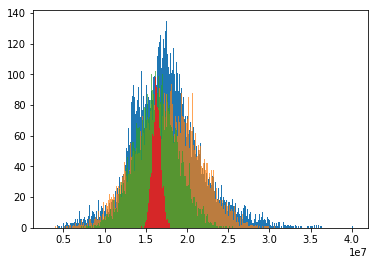

19


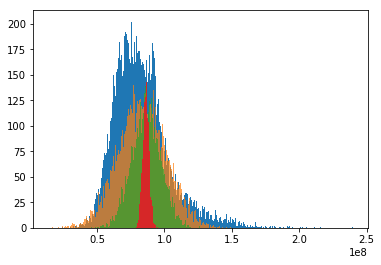

22


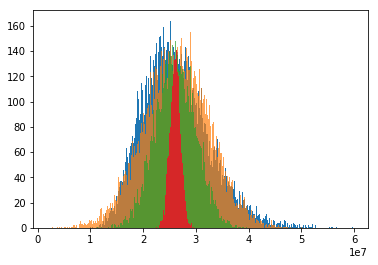

7


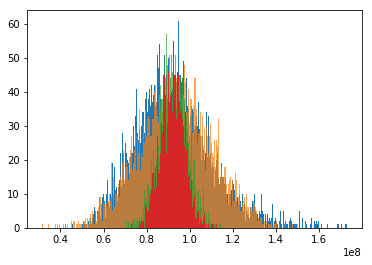

11


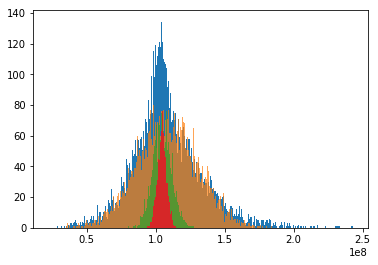

7


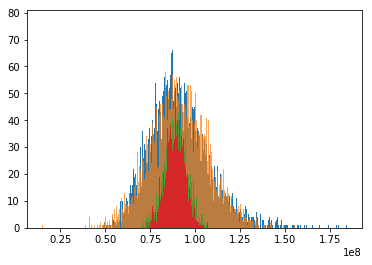

In [194]:
np.random.seed(10)
nbins=1000 # 
for i in ulist[0:50]:
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    if len(dummy) >5:
        print(len(dummy))
        tli=[]
        for km,ke in zip(dummy['m-M'],dummy['err']):
            tli+=list(10**(np.random.normal(km,ke,nbins)/5.+1)) # bootstrap draw for each gal
        booterr=np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0)
        fic=np.random.normal(np.mean(tli),np.mean(booterr)/2,len(tli))
        bins=500
        wnat,avnat = weighted_std(dummy['m-M'],1/dummy['err']**2)
        distwav=10**(avnat/5+1)
        wsti=0.461*distwav*wnat # weighted standard deviation
        ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
        eqd=np.sqrt(ecfi**2+wsti**2)   
        #    print(stats.anderson(tli,'norm'))
        fice=np.random.normal(distwav,ecfi,len(tli))
        ficq=np.random.normal(distwav,eqd,len(tli))

        plt.hist(tli,bins=bins)
        plt.hist(fic,bins=bins,alpha=0.7)
        plt.hist(ficq,bins=bins,alpha=0.7)
        plt.hist(fice,bins=bins)

        
        plt.show()
        
        

6


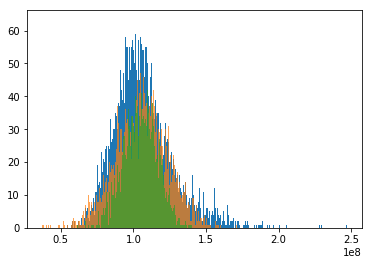

11


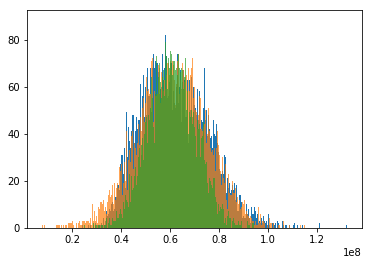

12


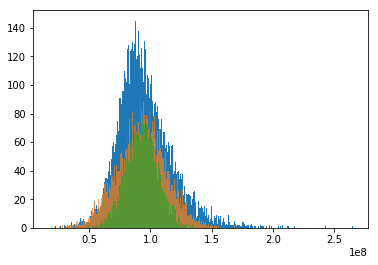

11


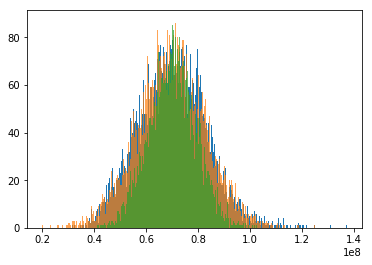

10


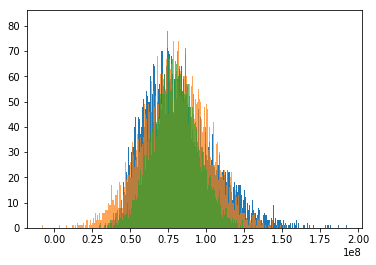

6


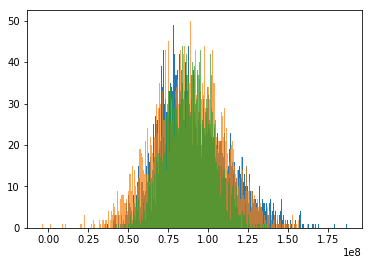

6


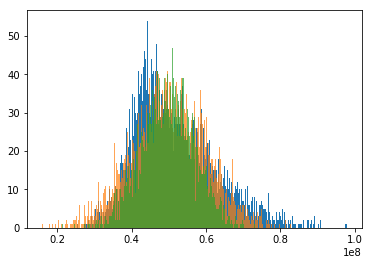

13


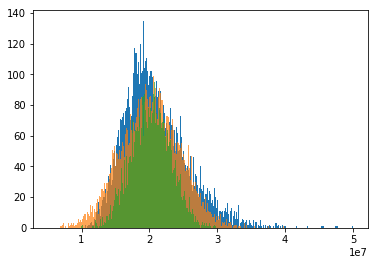

6


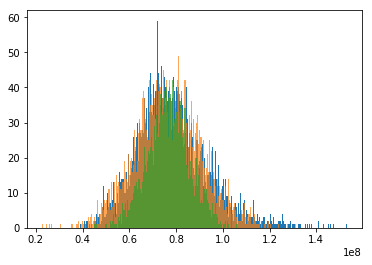

13


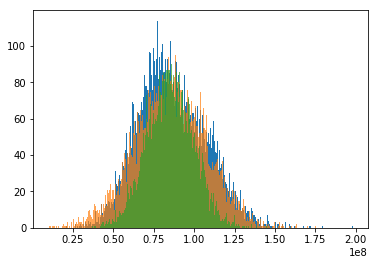

11


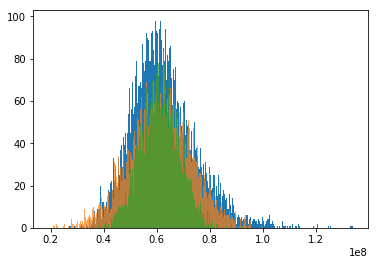

12


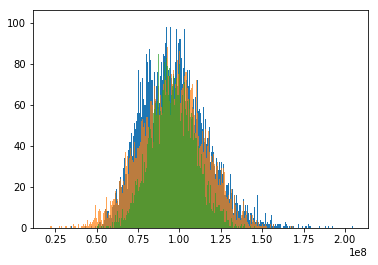

7


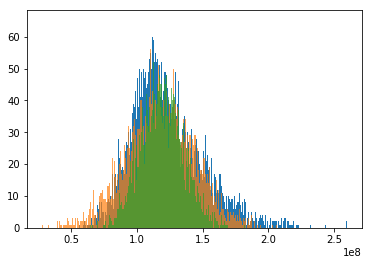

9


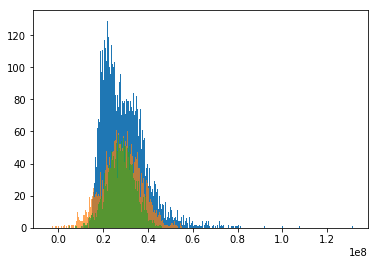

17


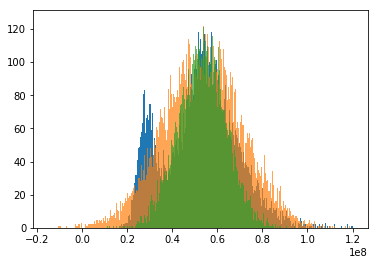

28


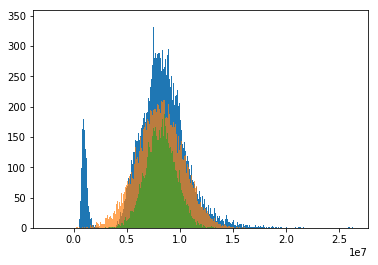

13


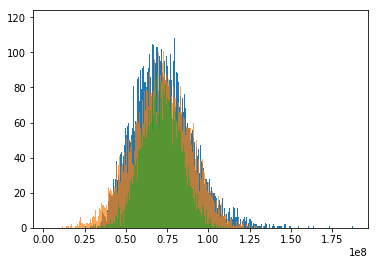

11


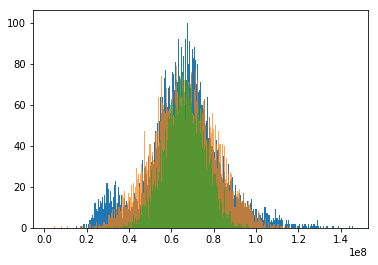

7


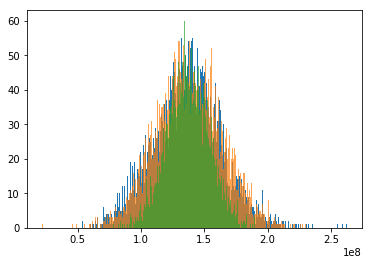

13


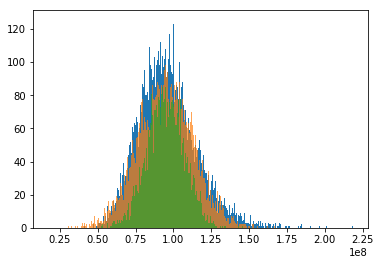

11


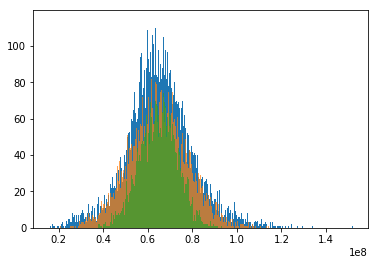

13


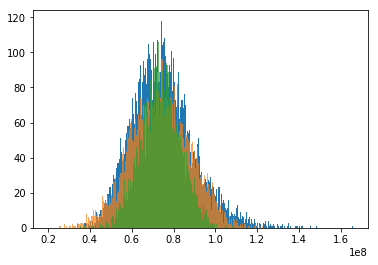

7


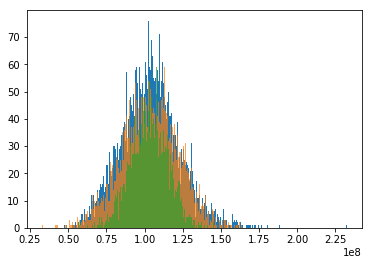

8


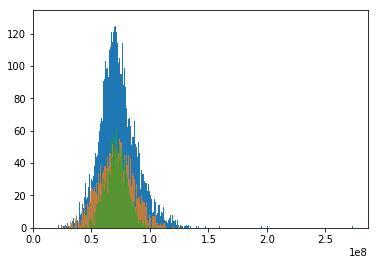

In [208]:
np.random.seed(10)
nbins=1000 # 
for i in ulist[50:100]:
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    if len(dummy) >5:
        print(len(dummy))
        tli=[]
        for km,ke in zip(dummy['m-M'],dummy['err']):
            tli+=list(10**(np.random.normal(km,ke,nbins)/5.+1)) # bootstrap draw for each gal
        booterr=np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0)
        fic=np.random.normal(np.median(tli),np.mean(booterr)/2,len(tli))
        ficd=np.random.normal(np.median(tli),np.median(np.abs(tli - np.median(tli))),len(tli))

#        ficm=np.random.normal(np.mean(tli),np.mean(booterr)/2,len(tli))

        bins=500


        plt.hist(tli,bins=bins)
        plt.hist(fic,bins=bins,alpha=0.7)
#        plt.hist(ficm,bins=bins,alpha=0.7)
        plt.hist(ficd,bins=bins,alpha=0.7)

        
        plt.show()

In [159]:
reso=300

15 20.1733333333 4484
19.5135351117 4.23345809078
13 60.1576923077 2015
63.8540571479 11.1641924401
8 99.6875 5559
99.1404687104 14.8657392822
11 130.0 9027
126.127311987 25.7442697622


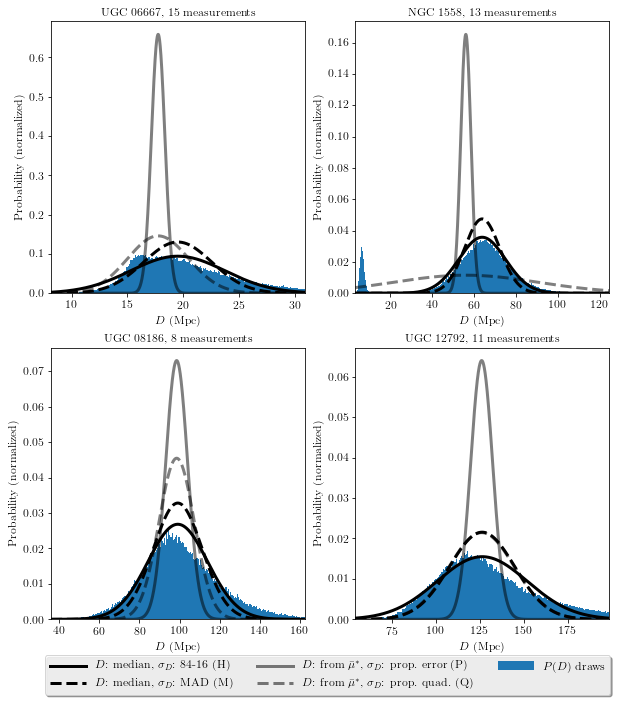

In [339]:
np.random.seed(10)
nbins=10000 # 
plt.figure(figsize=(10,11))
kp=220
for k in [4484,2015,5559,9027]:
    i=ulist[k]
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    if len(dummy) >5:# and np.round(dummy['D (Mpc)'].mean())==20:
        print(len(dummy),dummy['D (Mpc)'].mean(),k)
        tlic=[]
        for km,ke in zip(dummy['m-M'],dummy['err']):
            tlic+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))] # bootstrap draw for each gal
        tli=np.array(tlic)/1e6
        booterr=np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0)
        tli=tli.ravel()
        wnat,avnat = weighted_std(dummy['m-M'],1/dummy['err']**2)
        distwav=10**(avnat/5+1)/1e6
        wsti=0.461*distwav*wnat # weighted standard deviation
        ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
        eqd=np.sqrt(ecfi**2+wsti**2)   
        dmin=np.min(tli)
        dmax=2*np.median(tli)-dmin
        dar=np.linspace(dmin,dmax,len(tli)//10)
        
        ficp=gaussian(dar,distwav,ecfi)
        ficq=gaussian(dar,distwav,eqd)
        fich=gaussian(dar,np.median(tli),np.median(booterr)/2)
        print(np.median(tli),np.median(booterr)/2)
        ficm=gaussian(dar,np.median(tli),np.median(np.abs(tli - np.median(tli))))

        bins=len(tli.ravel())//200

        kp+=1
        plt.subplot(kp)

        a=plt.hist(tli,bins=bins,normed=True,label=r'$P(D)$ draws')
        plt.plot(dar,fich,label=r'$D$: median, $\sigma_D$: 84-16 (H)',c='k',linewidth=3)
        plt.plot(dar,ficm,'--',label=r'$D$: median, $\sigma_D$: MAD (M)',c='k',linewidth=3)
        plt.plot(dar,ficp,label=r'$D$: from $\bar{\mu}^*$, $\sigma_D$: prop. error (P)',c='k',alpha=0.5,linewidth=3)
        plt.plot(dar,ficq,'--',label=r'$D$: from $\bar{\mu}^*$, $\sigma_D$: prop. quad. (Q)',c='k',alpha=0.5,linewidth=3)
       
        plt.xlim(dmin,dmax)
        plt.xlabel(r"$D$ (Mpc)")
        plt.ylabel("Probability (normalized)")

        plt.title(i+", "+str(len(dummy))+" measurements")
#        if kp==221:
plt.legend(loc='upper center', bbox_to_anchor=(-0.11, -0.11), fancybox=True, shadow=True,ncol=3)
plt.savefig('mnras/comp.pdf', dpi=reso,transparent=True)
plt.show()

7 129.857142857 691


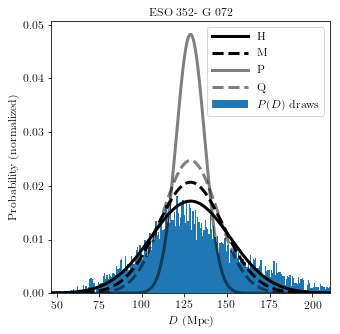

6 149.5 2288


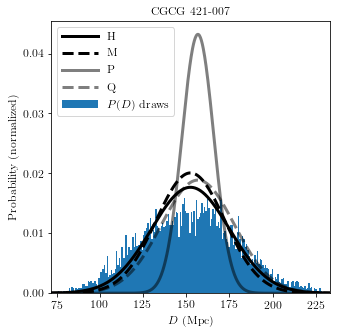

6 129.833333333 6378


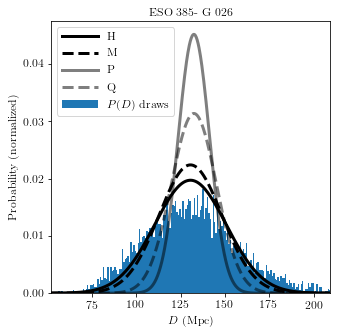

7 130.142857143 6612


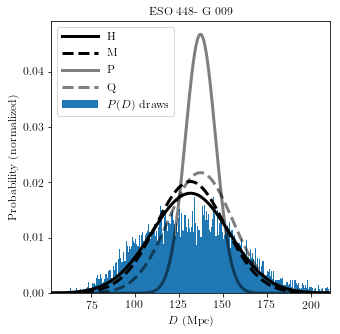

6 139.5 7019


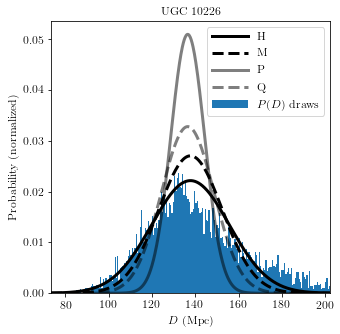

6 139.833333333 8686


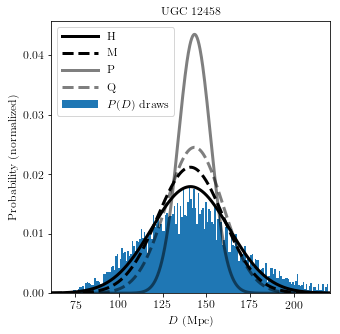

13 129.623076923 8958


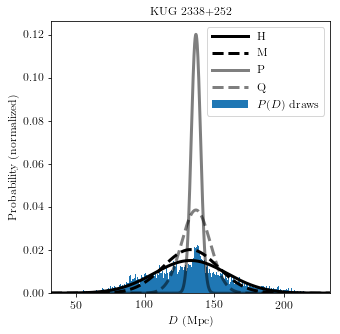

11 130.0 9027


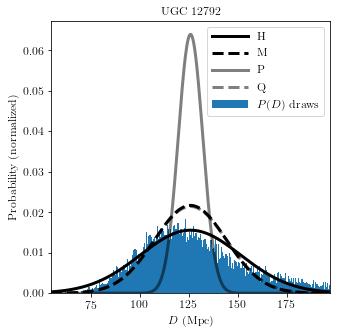

In [110]:
np.random.seed(10)
nbins=1000 # 
for k in range(len(ulist)):
    i=ulist[k]
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    if len(dummy) >5 and (np.round(dummy['D (Mpc)'].mean())==130 or np.round(dummy['D (Mpc)'].mean())==140 or np.round(dummy['D (Mpc)'].mean())==150):
        print(len(dummy),dummy['D (Mpc)'].mean(),k)
        tlic=[]
        for km,ke in zip(dummy['m-M'],dummy['err']):
            tlic+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))] # bootstrap draw for each gal
        tli=np.array(tlic)/1e6
        booterr=np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0)
        tli=tli.ravel()
        wnat,avnat = weighted_std(dummy['m-M'],1/dummy['err']**2)
        distwav=10**(avnat/5+1)/1e6
        wsti=0.461*distwav*wnat # weighted standard deviation
        ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
        eqd=np.sqrt(ecfi**2+wsti**2)   
        dmin=np.min(tli)
        dmax=2*np.median(tli)-dmin
        dar=np.linspace(dmin,dmax,len(tli)//10)
        
        ficp=gaussian(dar,distwav,ecfi)
        ficq=gaussian(dar,distwav,eqd)
        fich=gaussian(dar,np.median(tli),np.median(booterr)/2)
        ficm=gaussian(dar,np.median(tli),np.median(np.abs(tli - np.median(tli))))

        bins=len(tli.ravel())//20

        plt.figure(figsize=(5,5))

        a=plt.hist(tli,bins=bins,normed=True,label=r'$P(D)$ draws')
        norm=a[0].max()
        plt.plot(dar,fich,label='H',c='k',linewidth=3)
        plt.plot(dar,ficm,'--',label='M',c='k',linewidth=3)
        plt.plot(dar,ficp,label='P',c='k',alpha=0.5,linewidth=3)
        plt.plot(dar,ficq,'--',label='Q',c='k',alpha=0.5,linewidth=3)
#       
        plt.xlim(dmin,dmax)
        plt.xlabel(r"$D$ (Mpc)")
        plt.ylabel("Probability (normalized)")

        plt.title(i)
        plt.legend()
        
        plt.gray()

        plt.show()

In [389]:
np.random.seed(10)
nbins=10000 # 
kp=220
k=4484
i=ulist[k]
dfilter=np.in1d(dfs['Galaxy ID'],i)
dummy=dfs[dfilter]
if len(dummy) >5:# and np.round(dummy['D (Mpc)'].mean())==20:
    print(len(dummy),dummy['D (Mpc)'].mean(),k)
    tlic=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tlic+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))] # bootstrap draw for each gal
    tli=np.array(tlic)/1e6
    booterr=np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0)
    print(np.mean(booterr))
    bootmeder=np.abs(tli - np.median(tli))

15 20.1733333333 4484
8.63550875113


In [392]:
booterr.shape

(10000,)

In [398]:
np.median(tli,axis=0)

array([ 20.53567776,  18.72946315,  19.37793959, ...,  20.77378284,
        17.79573159,  18.08791351])

In [415]:
%%time
mymed=np.median(tli,axis=0)
ast=[np.median(np.abs(tli[:,i]-mymed[i])) for i in range(nbins)]

CPU times: user 268 ms, sys: 0 ns, total: 268 ms
Wall time: 265 ms


In [414]:
tli[:,0]-np.median(tli,axis=0)[0]

array([-3.73623396, -9.18442377, -1.77177009, -4.25379455, -3.58953462,
        1.10179529,  1.60253587, -1.33633439, -4.54279988,  0.        ,
        4.80276   ,  2.79043437,  2.53633066,  1.99992886,  4.24415424])

In [413]:
d/2

0.88739565503441153

In [369]:

i='NGC 1058'
dfilter=np.in1d(dfs['Galaxy ID'],i)
dummy=dfs[dfilter]

In [371]:
dummy

,Galaxy ID,m-M,err,D (Mpc)
49467,NGC 1058,26.43,0.50,1.93
49471,NGC 1058,26.88,8.66,2.37
49472,NGC 1058,27.54,6.39,3.21
49474,NGC 1058,29.80,0.40,9.10
49475,NGC 1058,29.90,0.20,9.55


In [378]:
dmin=1e5
dmax=100e6

In [379]:
dar=np.linspace(dmin,dmax,100)

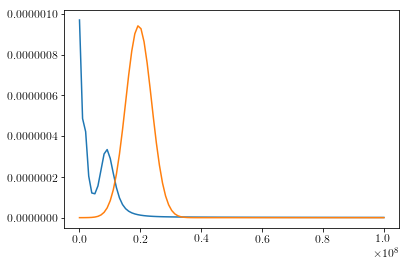

In [380]:
ga=np.zeros(len(dar))
for kk in range(len(dummy)):
#    plt.plot(dar,lognormal(dar,np.log(dummy['D (Mpc)']*1e6).iloc[kk],dummy.err.iloc[kk]))
    ga+=lognormal(dar,np.log(dummy['D (Mpc)']*1e6).iloc[kk],dummy.err.iloc[kk])
plt.plot(dar,ga)
plt.plot(dar,10*gaussian(dar,19.5135351117e6, 4.23345809078e6))

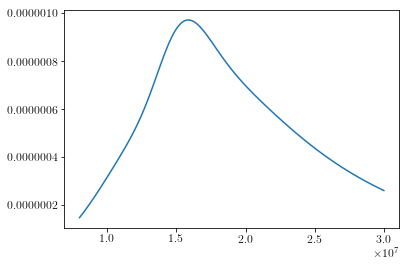

In [337]:
plt.plot(dar,ga)


In [365]:
df.D

4              3
5              4
6              5
7              6
8              7
9              8
10             9
11            10
12            11
13            12
14            13
15            14
18            17
19            18
20        999999
23        999999
24        999999
25            19
26            20
27            21
28            22
29            23
30            24
31            25
32            26
33            27
34            28
35            29
36            30
45            35
           ...  
319650    999999
319651    999999
319655    999999
319656    999999
319658    268076
319659    268077
319660    268078
319661    268079
319662    268080
319663    268081
319664    268082
319667    268084
319668    268085
319669    268086
319670    268087
319671    268088
319672    999999
319673    268089
319674    268090
319675    268091
319676    268092
319677    268093
319678    268094
319679    268095
319680    268096
319681    268097
319682    268098
319683    2680

In [368]:
df

,Exclusion Code,D,G,Galaxy ID,m-M,err,D (Mpc),Method,REFCODE,SN ID,redshift (z),Hubble const.,Adopted LMC modulus,Date (Yr. - 1980),Notes
4,NaN,3,2,2MASX J00000138+1530350,38.86,0.46,592.0,FP,2016A&A...596A..14S,NaN,NaN,70.0,NaN,36,NaN
5,NaN,4,3,2MASX J00000155-0929403,39.79,0.46,910.0,FP,2016A&A...596A..14S,NaN,NaN,70.0,NaN,36,NaN
6,NaN,5,4,UGC 12889,33.65,0.66,53.7,Tully-Fisher,1984A&AS...56..381B,NaN,NaN,103.0,NaN,4,Diameter
7,NaN,6,4,UGC 12889,34.16,0.40,68.0,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,mean
8,NaN,7,4,UGC 12889,34.66,0.45,85.6,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,K
9,NaN,8,4,UGC 12889,34.68,0.47,86.1,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,H
10,NaN,9,4,UGC 12889,34.70,0.46,86.9,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,J
11,NaN,10,5,KUG 2357+228,33.52,0.20,50.6,Tully-Fisher,2013AJ....146...86T,NaN,NaN,74.4,NaN,33,NaN
12,NaN,11,5,KUG 2357+228,33.73,0.37,55.8,Tully-Fisher,2009ApJS..182..474S,NaN,NaN,NaN,NaN,29,NaN
13,NaN,12,5,KUG 2357+228,34.11,0.31,66.3,Tully-Fisher,2009ApJS..182..474S,NaN,NaN,NaN,NaN,29,Malmquist cor.
